In [526]:
#Created By : Debayan Dutta
#Creation Date : 19-05-2020
#Last Modification Date : --
#Problem Statement : a)	Build a model to find out who are the customers to target to increase the Brand_TRx  
#                    b)	Also build a model to determine optimum expected Brand_TRx from the customer if targeted based 
#                       on “Channels_Interacted”

In [527]:
# Importing the relevant libraries :
# For EDA
import csv
import os
import numpy as np
import pandas as pd
from itertools import groupby

#For Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#inititate Plotly
pyoff.init_notebook_mode()

# For cluster model
from sklearn.cluster import KMeans

# For regression model
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# For accuracy checks
from sklearn.metrics import r2_score

In [528]:
# Setting directory
os.chdir(r"C:\Users\DebayanDutta\Desktop\Indegene")

In [529]:
# Importing Dataset
df = pd.read_csv("Data.csv")

In [530]:
df.head(3)

ID   Region                            Channels Interacted New  \
0  IND100353  Midwest  {"Web","Call","Web","Web","Call","Web","Email"...   
1  IND100495  Midwest                           {"Email","Call","Email"}   
2  IND100532     West                                   {"Call","Email"}   

   Experience                                           Feedback  \
0         5.0  Caller called yesterday, but she did not recei...   
1         4.0  Called this office today already: I wasn't rem...   
2        14.0  Ice packs warm, Medication was hot. Unsure of ...   

            Speciality  Coverage  Population  Brand_TRx  Maket_TRx  
0  PHYSICIAN ASSISTANT      52.5     6053454         21         32  
1      FAMILY PRACTICE      39.5     8071890         15         31  
2                Other      80.4     5180868         31         40

In [531]:
df.tail(3)

ID Region                            Channels Interacted New  \
6020  IND999584   West                    {"Call","Email","Call","Email"}   
6021  IND999768   West                            {"Call","Email","Call"}   
6022  IND999828  South  {"Call","Web","Email","Call","Email","Web","Em...   

      Experience                                           Feedback  \
6020         7.0  disconnected the line when trying to get in to...   
6021        14.0       The line rung 3 times and then disconnected    
6022         3.0  Caller stated that she receives meds at a disc...   

               Speciality  Coverage  Population  Brand_TRx  Maket_TRx  
6020      FAMILY PRACTICE      68.0     4840590         26         26  
6021  PHYSICIAN ASSISTANT      51.3     1912500         23         31  
6022           PEDIATRICS      50.4     2683380         20         33

In [532]:
# Summary checks
df.shape

(6023, 10)

In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6023 entries, 0 to 6022
Data columns (total 10 columns):
ID                         6023 non-null object
Region                     6010 non-null object
Channels Interacted New    6023 non-null object
Experience                 6013 non-null float64
Feedback                   6023 non-null object
Speciality                 6010 non-null object
Coverage                   6023 non-null float64
Population                 6023 non-null int64
Brand_TRx                  6023 non-null int64
Maket_TRx                  6023 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 352.9+ KB


In [534]:
df.describe()

Experience     Coverage    Population    Brand_TRx    Maket_TRx
count  6013.000000  6023.000000  6.023000e+03  6023.000000  6023.000000
mean      7.511891    49.919343  4.972295e+06    20.468039    30.503902
std       4.655790    28.664570  2.322111e+06     8.822501    10.671911
min       0.000000     0.000000  1.001717e+06     2.000000     3.000000
25%       3.000000    24.900000  2.930048e+06    13.000000    23.000000
50%       8.000000    50.300000  4.946585e+06    21.000000    30.000000
75%      12.000000    74.500000  6.974941e+06    28.000000    38.000000
max      15.000000   100.000000  8.999971e+06    39.000000    58.000000

In [536]:
df.corr()

Experience  Coverage  Population  Brand_TRx  Maket_TRx
Experience    1.000000  0.000998    0.028413   0.213372   0.175444
Coverage      0.000998  1.000000   -0.005808   0.974404   0.804229
Population    0.028413 -0.005808    1.000000   0.000507  -0.006504
Brand_TRx     0.213372  0.974404    0.000507   1.000000   0.825659
Maket_TRx     0.175444  0.804229   -0.006504   0.825659   1.000000

#### Data Cleaning Ph 1

In [537]:
# Since we have data for every other channel, we would, for now, fill the missing values of the columns Region and Coverage
# with 'Not Disclosed'
df['Experience'] = df['Experience'].fillna("-1")

In [539]:
df = df.fillna("Not Disclosed")

In [540]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6023 entries, 0 to 6022
Data columns (total 10 columns):
ID                         6023 non-null object
Region                     6023 non-null object
Channels Interacted New    6023 non-null object
Experience                 6023 non-null object
Feedback                   6023 non-null object
Speciality                 6023 non-null object
Coverage                   6023 non-null float64
Population                 6023 non-null int64
Brand_TRx                  6023 non-null int64
Maket_TRx                  6023 non-null int64
dtypes: float64(1), int64(3), object(6)
memory usage: 329.4+ KB


#### Data Cleaning Ph 2 -- Adding new features

In [541]:
df['Brand_TRx'] = df['Brand_TRx'].astype(float)
df['Maket_TRx'] = df['Maket_TRx'].astype(float)

In [542]:
df['TRx_Ratio'] = (df['Brand_TRx'] / df['Maket_TRx'])

In [543]:
# CHANNELS

In [544]:
channels = []

In [545]:
for i in df['Channels Interacted New']:
    channels.append(i)

In [546]:
# Function for collecting frequencies of every channel
def CountFrequency(my_list):
    # Creating an empty dictionary
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq

In [547]:
index = 0
channel_per_id = []
for i in channels:
    i = i.replace("{","")
    i = i.replace("}","")
    i = i.replace('"',"")
    i = i.lstrip()
    i = i.rstrip()
    
    my_list = i.split(",")
    channel_per_id.append(my_list)

In [549]:
freq_of_channels = [] # List containing dictionaries of ID wise frequency of every channel
for i in channel_per_id:
    freq_of_channels.append(CountFrequency(i))

In [550]:
df_channels = pd.DataFrame(freq_of_channels)

In [551]:
df_channels.head(5)

Call  Email  Web
0   2.0    2.0  4.0
1   1.0    2.0  NaN
2   1.0    1.0  NaN
3   NaN    1.0  1.0
4   1.0    2.0  1.0

In [552]:
df_channels = df_channels.fillna(0)

In [553]:
df_channels.insert(loc = 3, column = 'Total_Spending', value = (df_channels["Call"]*100) + df_channels["Email"] + (df_channels["Email"]*5))

In [554]:
df_channels.insert(loc=0, column='ID', value=df['ID'])

In [555]:
df_channels.head(5)

ID  Call  Email  Web  Total_Spending
0  IND100353   2.0    2.0  4.0           212.0
1  IND100495   1.0    2.0  0.0           112.0
2  IND100532   1.0    1.0  0.0           106.0
3  IND100964   0.0    1.0  1.0             6.0
4  IND100998   1.0    2.0  1.0           112.0

In [556]:
# Checking if the data is unique on ID level:
df['ID'].nunique()

6023

In [557]:
# Count of ID is equal to the count of unique IDs...so all the values are unique.

In [558]:
# Final master Dataset
df_master = pd.merge(df, df_channels, on='ID')

In [559]:
df_master = df_master.drop(["Channels Interacted New"], axis = 1)

In [560]:
#df_master
df_master.to_csv(r'Master_data.csv')

In [561]:
df_master.head(5)

ID     Region Experience  \
0  IND100353    Midwest          5   
1  IND100495    Midwest          4   
2  IND100532       West         14   
3  IND100964  Northeast          7   
4  IND100998       West         15   

                                            Feedback           Speciality  \
0  Caller called yesterday, but she did not recei...  PHYSICIAN ASSISTANT   
1  Called this office today already: I wasn't rem...      FAMILY PRACTICE   
2  Ice packs warm, Medication was hot. Unsure of ...                Other   
3                     Call on different time and day          DERMATOLOGY   
4  Missed dose on 9-19 and administered on 10-10....                Other   

   Coverage  Population  Brand_TRx  Maket_TRx  TRx_Ratio  Call  Email  Web  \
0      52.5     6053454       21.0       32.0   0.656250   2.0    2.0  4.0   
1      39.5     8071890       15.0       31.0   0.483871   1.0    2.0  0.0   
2      80.4     5180868       31.0       40.0   0.775000   1.0    1.0  0.0   
3      97.9     6765978       34.0       45.0   0.755556   0.0    1.0  1.0   
4      94.2     6759099       36.0       40.0   0.900000   1.0    2.0  1.0   

   Total_Spending  
0           212.0  
1           112.0  
2           106.0  
3             6.0  
4           112.0

#### Exploratory Data Analysis

In [562]:
# Univariates

In [563]:
# Distribution Plots for Numerical Variables

In [564]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

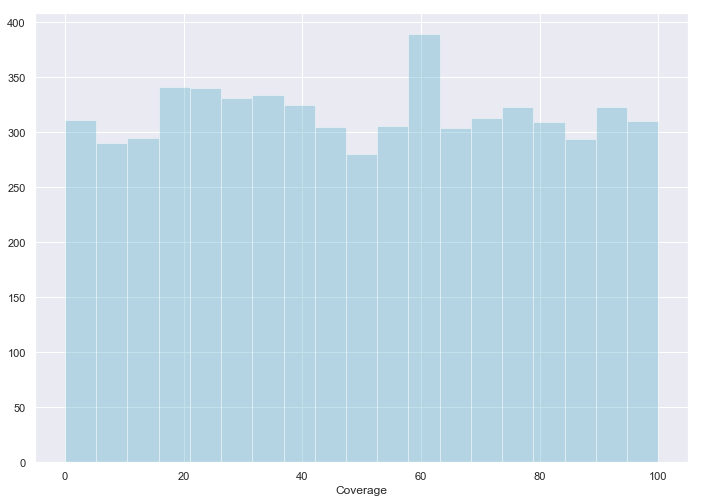

In [565]:
# Coverage
plot = sns.distplot(df_master.Coverage, kde=False, color = "c" )

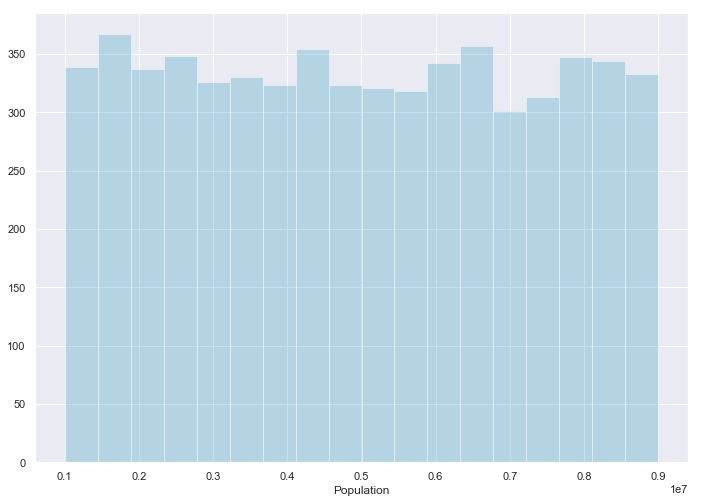

In [566]:
# Population
plot = sns.distplot(df_master.Population, kde=False, color = "c" )

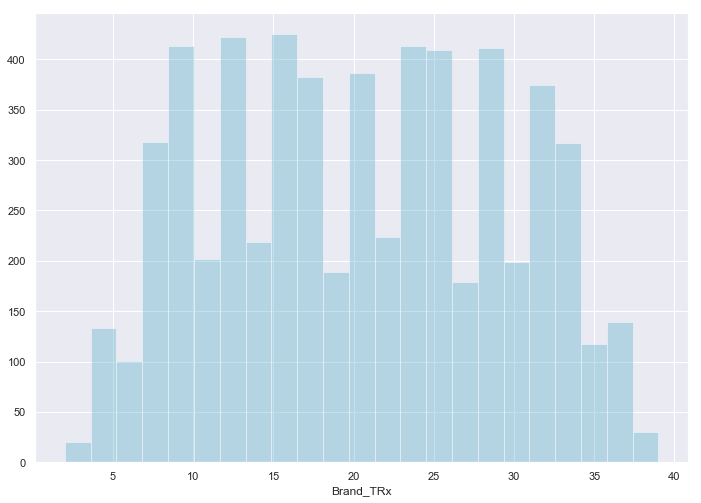

In [567]:
# Brand_TRx
plot = sns.distplot(df_master.Brand_TRx, kde=False, color = "c" )

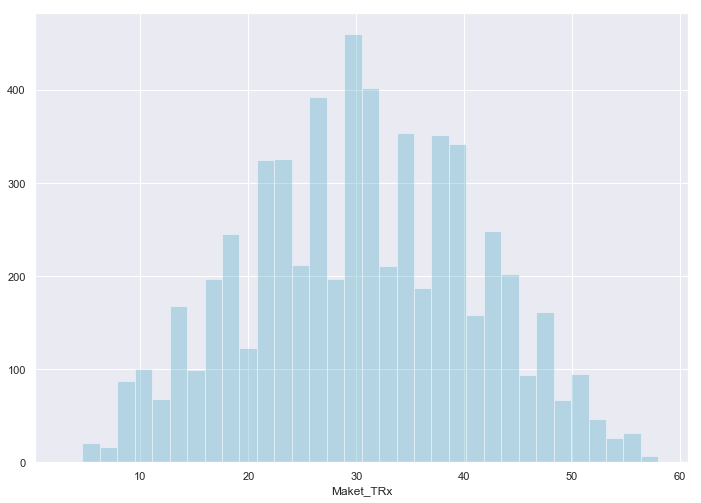

In [568]:
# Maket_TRx
plot = sns.distplot(df_master.Maket_TRx, kde=False, color = "c" )

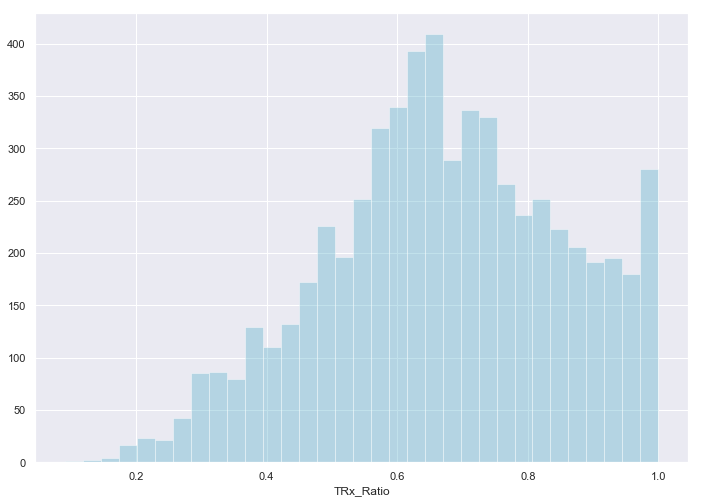

In [569]:
# TRx_Ratio
plot = sns.distplot(df_master.TRx_Ratio, kde=False, color = "c" )

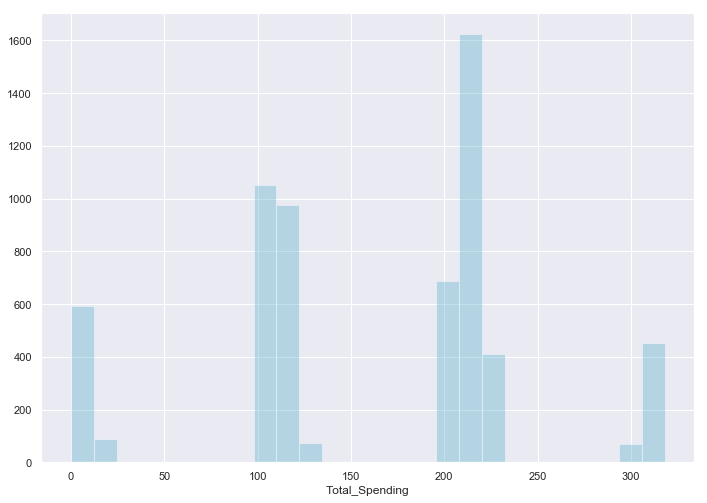

In [570]:
# Total_Spending
plot = sns.distplot(df_master.Total_Spending, kde=False, color = "c" )

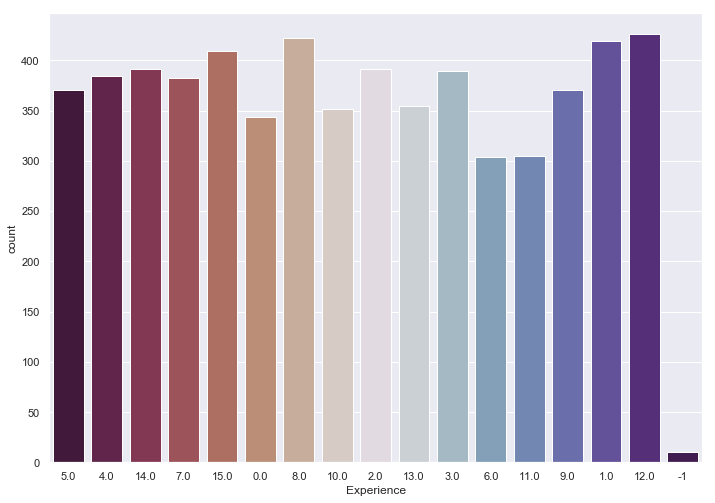

In [571]:
# Working with the variable experience
sns.countplot(x="Experience", data=df_master, palette="twilight_shifted_r")

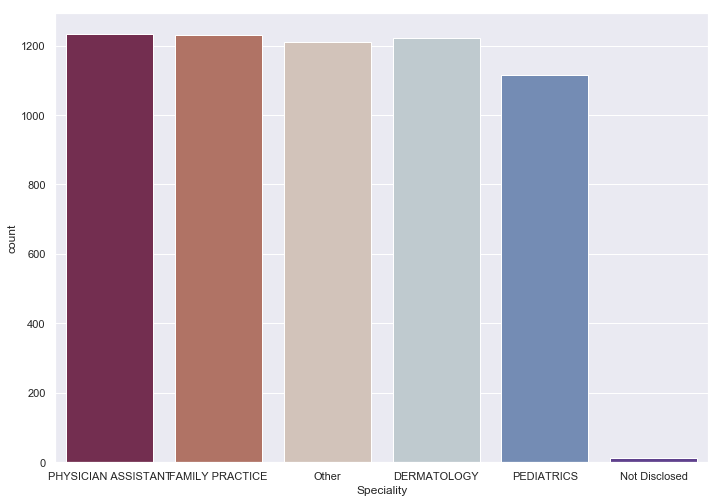

In [572]:
# Categorical -- Countplots
#Speciality 
sns.countplot(x="Speciality", data=df_master, palette="twilight_shifted_r")

In [573]:
# Bivariates

In [574]:
# HCP segment

In [575]:
# We are going to segment out HCPs based on their reach and precribing habits, into 4 parts --
segment = []
for i in range(0,6023):
    if(df_master.loc[i , 'Maket_TRx'] > 30 and df_master.loc[i , 'TRx_Ratio'] > 0.5):
        segment.append("High Potential - High Reach")
    elif(df_master.loc[i , 'Maket_TRx'] > 30 and df_master.loc[i , 'TRx_Ratio'] < 0.5):
        segment.append("High Potential - Low Reach")
    elif(df_master.loc[i , 'Maket_TRx'] < 30 and df_master.loc[i , 'TRx_Ratio'] > 0.5):
        segment.append("Low Potential - High Reach")
    elif(df_master.loc[i , 'Maket_TRx'] < 30 and df_master.loc[i , 'TRx_Ratio'] < 0.5):
        segment.append("Low Potential - Low Reach")
    else:
        segment.append("NA")

In [576]:
len(segment)

6023

In [577]:
df_master['HCP_Segment'] = segment

In [578]:
df_eda = df_master.drop(['Feedback', 'Population', 'Call', 'Email', 'Web'], axis = 1)

In [579]:
df_eda.head(5)

ID     Region Experience           Speciality  Coverage  Brand_TRx  \
0  IND100353    Midwest          5  PHYSICIAN ASSISTANT      52.5       21.0   
1  IND100495    Midwest          4      FAMILY PRACTICE      39.5       15.0   
2  IND100532       West         14                Other      80.4       31.0   
3  IND100964  Northeast          7          DERMATOLOGY      97.9       34.0   
4  IND100998       West         15                Other      94.2       36.0   

   Maket_TRx  TRx_Ratio  Total_Spending                  HCP_Segment  
0       32.0   0.656250           212.0  High Potential - High Reach  
1       31.0   0.483871           112.0   High Potential - Low Reach  
2       40.0   0.775000           106.0  High Potential - High Reach  
3       45.0   0.755556             6.0  High Potential - High Reach  
4       40.0   0.900000           112.0  High Potential - High Reach

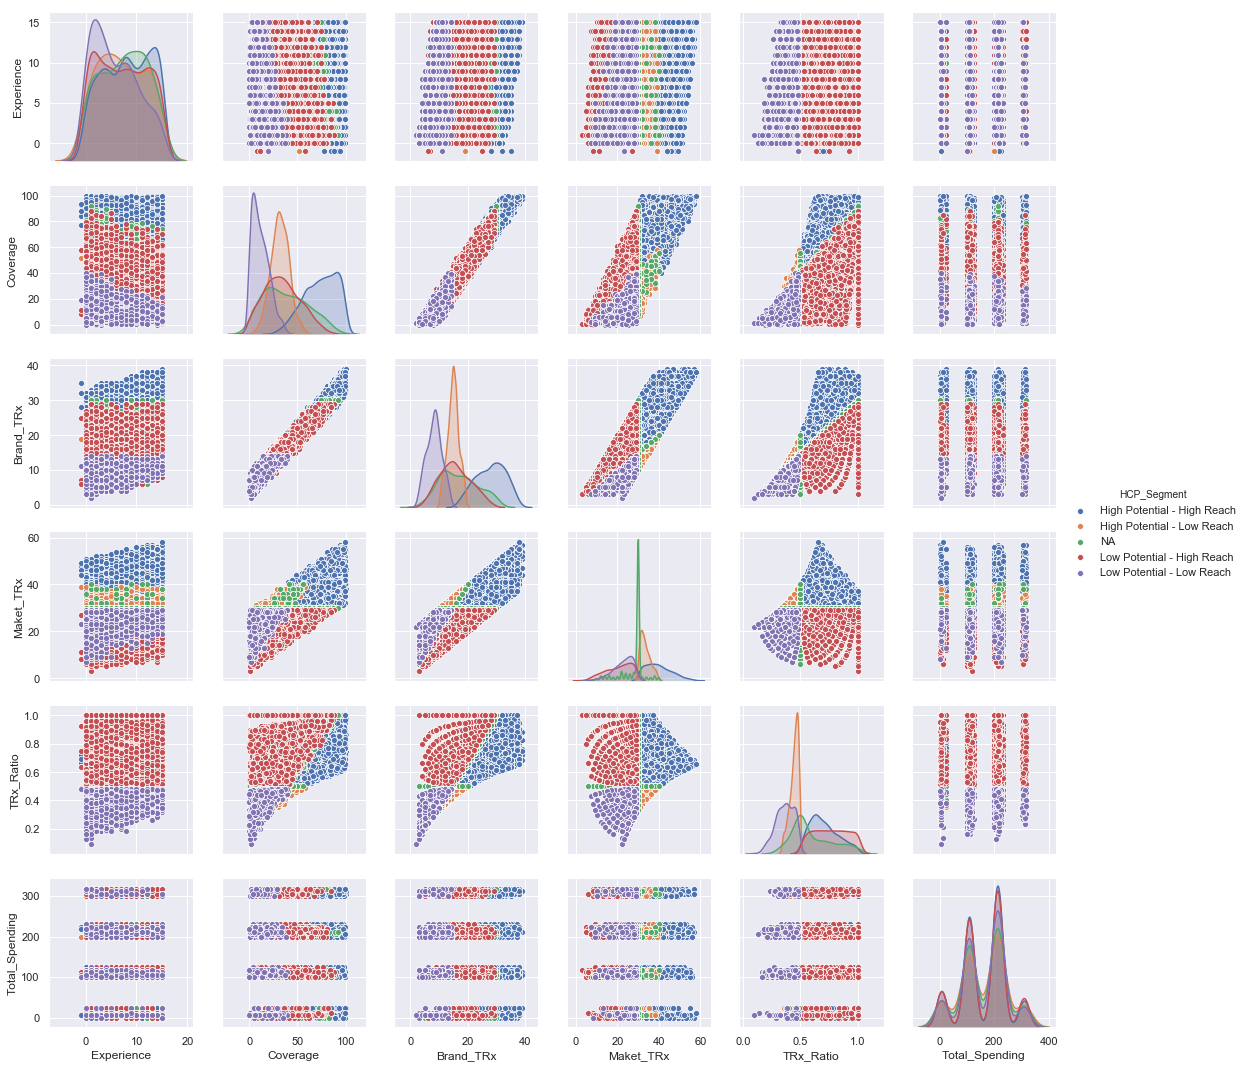

In [580]:
sns.pairplot(df_eda , hue = "HCP_Segment")

In [581]:
# Experience

In [582]:
#df_eda["Experience"] = float(df_eda["Experience"])
experience = []
df_eda.Experience = df_eda.Experience.astype('int64')

for i in range(0,6023):
    if(df_eda.loc[i , 'Experience'] >= 0 and df_eda.loc[i , 'Experience'] < 6):
        experience.append("Bad")
    elif(df_eda.loc[i , 'Experience'] > 5 and df_eda.loc[i , 'Experience'] < 10):
        experience.append("Good")
    elif(df_eda.loc[i , 'Experience'] > 9 and df_eda.loc[i , 'Experience'] <= 15):
        experience.append("Great")
    else:
        experience.append("NA")

In [583]:
df_eda['Experience_c'] = experience

In [584]:
df_master['Experience_c'] = experience

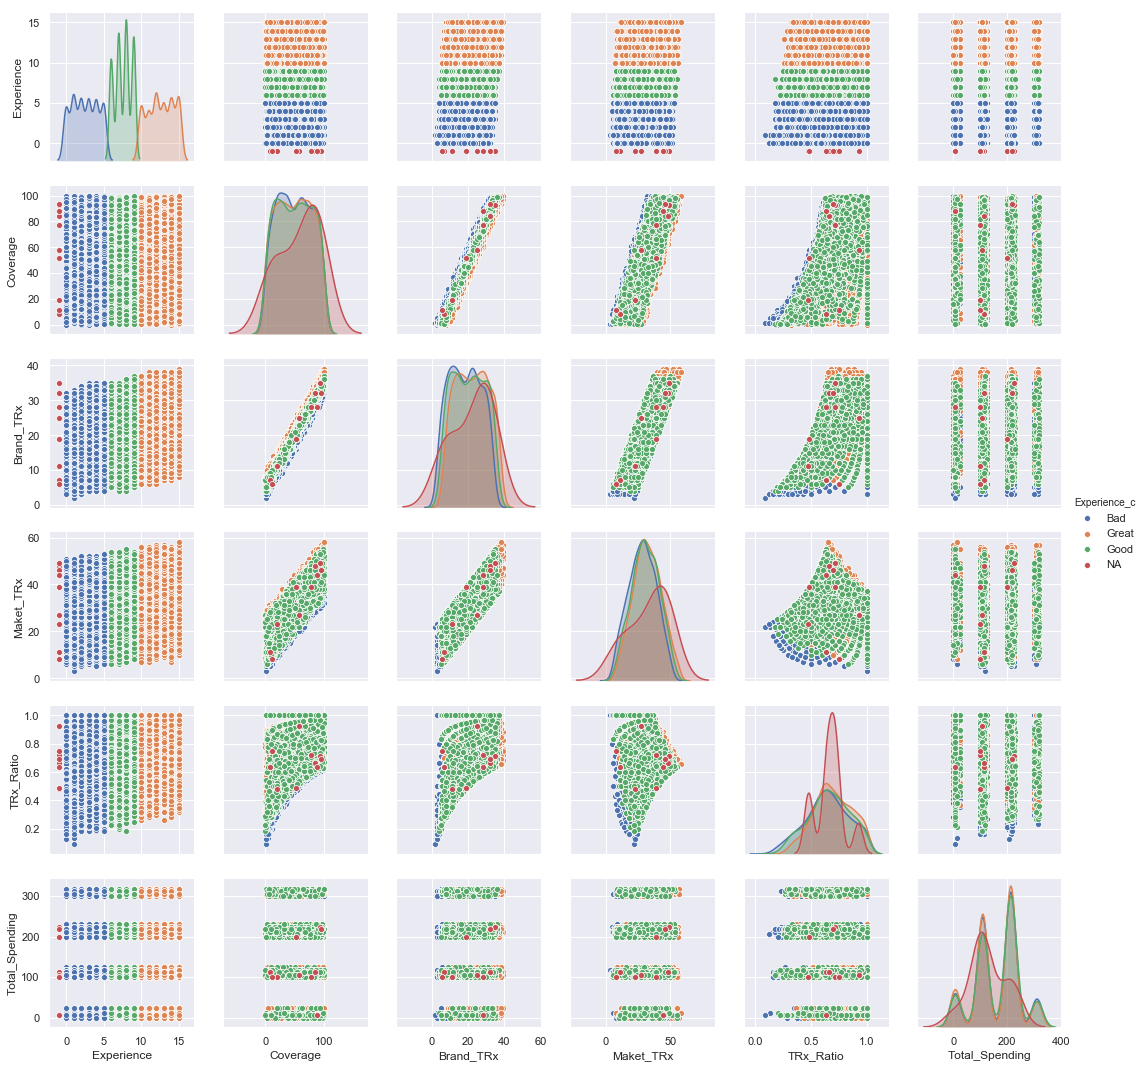

In [585]:
sns.pairplot(df_eda , hue = "Experience_c")

In [586]:
# Correlation Matrix

In [587]:
df_master.head(5)

ID     Region Experience  \
0  IND100353    Midwest          5   
1  IND100495    Midwest          4   
2  IND100532       West         14   
3  IND100964  Northeast          7   
4  IND100998       West         15   

                                            Feedback           Speciality  \
0  Caller called yesterday, but she did not recei...  PHYSICIAN ASSISTANT   
1  Called this office today already: I wasn't rem...      FAMILY PRACTICE   
2  Ice packs warm, Medication was hot. Unsure of ...                Other   
3                     Call on different time and day          DERMATOLOGY   
4  Missed dose on 9-19 and administered on 10-10....                Other   

   Coverage  Population  Brand_TRx  Maket_TRx  TRx_Ratio  Call  Email  Web  \
0      52.5     6053454       21.0       32.0   0.656250   2.0    2.0  4.0   
1      39.5     8071890       15.0       31.0   0.483871   1.0    2.0  0.0   
2      80.4     5180868       31.0       40.0   0.775000   1.0    1.0  0.0   
3      97.9     6765978       34.0       45.0   0.755556   0.0    1.0  1.0   
4      94.2     6759099       36.0       40.0   0.900000   1.0    2.0  1.0   

   Total_Spending                  HCP_Segment Experience_c  
0           212.0  High Potential - High Reach          Bad  
1           112.0   High Potential - Low Reach          Bad  
2           106.0  High Potential - High Reach        Great  
3             6.0  High Potential - High Reach         Good  
4           112.0  High Potential - High Reach        Great

In [588]:
# Dataset for correlation matrix
df_corr = df_master.drop(['Feedback', 'Speciality', 'HCP_Segment', 'Experience_c','ID','Region'], axis = 1)

In [589]:
df_corr.Experience = df_corr.Experience.astype('int64')

In [590]:
df_corr.head(5)

Experience  Coverage  Population  Brand_TRx  Maket_TRx  TRx_Ratio  Call  \
0           5      52.5     6053454       21.0       32.0   0.656250   2.0   
1           4      39.5     8071890       15.0       31.0   0.483871   1.0   
2          14      80.4     5180868       31.0       40.0   0.775000   1.0   
3           7      97.9     6765978       34.0       45.0   0.755556   0.0   
4          15      94.2     6759099       36.0       40.0   0.900000   1.0   

   Email  Web  Total_Spending  
0    2.0  4.0           212.0  
1    2.0  0.0           112.0  
2    1.0  0.0           106.0  
3    1.0  1.0             6.0  
4    2.0  1.0           112.0

In [591]:
df_corr.corr()

Experience  Coverage  Population  Brand_TRx  Maket_TRx  \
Experience        1.000000  0.000089    0.027517   0.211904   0.173859   
Coverage          0.000089  1.000000   -0.005808   0.974404   0.804229   
Population        0.027517 -0.005808    1.000000   0.000507  -0.006504   
Brand_TRx         0.211904  0.974404    0.000507   1.000000   0.825659   
Maket_TRx         0.173859  0.804229   -0.006504   0.825659   1.000000   
TRx_Ratio         0.121686  0.505324    0.004769   0.520831  -0.019612   
Call             -0.011274 -0.036054    0.005183  -0.005247  -0.008771   
Email             0.011539  0.009856   -0.016576   0.038799   0.025402   
Web               0.003090  0.026504    0.012670   0.056418   0.062383   
Total_Spending   -0.010039 -0.034440    0.003642  -0.001787  -0.006392   

                TRx_Ratio      Call     Email       Web  Total_Spending  
Experience       0.121686 -0.011274  0.011539  0.003090       -0.010039  
Coverage         0.505324 -0.036054  0.009856  0.026504       -0.034440  
Population       0.004769  0.005183 -0.016576  0.012670        0.003642  
Brand_TRx        0.520831 -0.005247  0.038799  0.056418       -0.001787  
Maket_TRx       -0.019612 -0.008771  0.025402  0.062383       -0.006392  
TRx_Ratio        1.000000  0.007688  0.028167  0.011555        0.009957  
Call             0.007688  1.000000  0.203755 -0.210717        0.996422  
Email            0.028167  0.203755  1.000000 -0.174866        0.285771  
Web              0.011555 -0.210717 -0.174866  1.000000       -0.221353  
Total_Spending   0.009957  0.996422  0.285771 -0.221353        1.000000

#### ---------- EDA ends here ---------------------------------------

#### Model Fittment

In [592]:
df_master.head(5)

ID     Region Experience  \
0  IND100353    Midwest          5   
1  IND100495    Midwest          4   
2  IND100532       West         14   
3  IND100964  Northeast          7   
4  IND100998       West         15   

                                            Feedback           Speciality  \
0  Caller called yesterday, but she did not recei...  PHYSICIAN ASSISTANT   
1  Called this office today already: I wasn't rem...      FAMILY PRACTICE   
2  Ice packs warm, Medication was hot. Unsure of ...                Other   
3                     Call on different time and day          DERMATOLOGY   
4  Missed dose on 9-19 and administered on 10-10....                Other   

   Coverage  Population  Brand_TRx  Maket_TRx  TRx_Ratio  Call  Email  Web  \
0      52.5     6053454       21.0       32.0   0.656250   2.0    2.0  4.0   
1      39.5     8071890       15.0       31.0   0.483871   1.0    2.0  0.0   
2      80.4     5180868       31.0       40.0   0.775000   1.0    1.0  0.0   
3      97.9     6765978       34.0       45.0   0.755556   0.0    1.0  1.0   
4      94.2     6759099       36.0       40.0   0.900000   1.0    2.0  1.0   

   Total_Spending                  HCP_Segment Experience_c  
0           212.0  High Potential - High Reach          Bad  
1           112.0   High Potential - Low Reach          Bad  
2           106.0  High Potential - High Reach        Great  
3             6.0  High Potential - High Reach         Good  
4           112.0  High Potential - High Reach        Great

In [593]:
# Model I:
def segmentation():
    segment = []
    for i in range(0,6023):
        if(df_master.loc[i , 'Maket_TRx'] > 30 and df_master.loc[i , 'TRx_Ratio'] > 0.5):
            segment.append("High Potential - High Reach")
        elif(df_master.loc[i , 'Maket_TRx'] > 30 and df_master.loc[i , 'TRx_Ratio'] < 0.5):
            segment.append("High Potential - Low Reach")
        elif(df_master.loc[i , 'Maket_TRx'] < 30 and df_master.loc[i , 'TRx_Ratio'] > 0.5):
            segment.append("Low Potential - High Reach")
        elif(df_master.loc[i , 'Maket_TRx'] < 30 and df_master.loc[i , 'TRx_Ratio'] < 0.5):
            segment.append("Low Potential - Low Reach")
        else:
            segment.append("NA")
    df_master['HCP_Segment'] = segment
    return df_master

In [594]:
df_eda.head(5)

ID     Region  Experience           Speciality  Coverage  Brand_TRx  \
0  IND100353    Midwest           5  PHYSICIAN ASSISTANT      52.5       21.0   
1  IND100495    Midwest           4      FAMILY PRACTICE      39.5       15.0   
2  IND100532       West          14                Other      80.4       31.0   
3  IND100964  Northeast           7          DERMATOLOGY      97.9       34.0   
4  IND100998       West          15                Other      94.2       36.0   

   Maket_TRx  TRx_Ratio  Total_Spending                  HCP_Segment  \
0       32.0   0.656250           212.0  High Potential - High Reach   
1       31.0   0.483871           112.0   High Potential - Low Reach   
2       40.0   0.775000           106.0  High Potential - High Reach   
3       45.0   0.755556             6.0  High Potential - High Reach   
4       40.0   0.900000           112.0  High Potential - High Reach   

  Experience_c  
0          Bad  
1          Bad  
2        Great  
3         Good  
4        Great

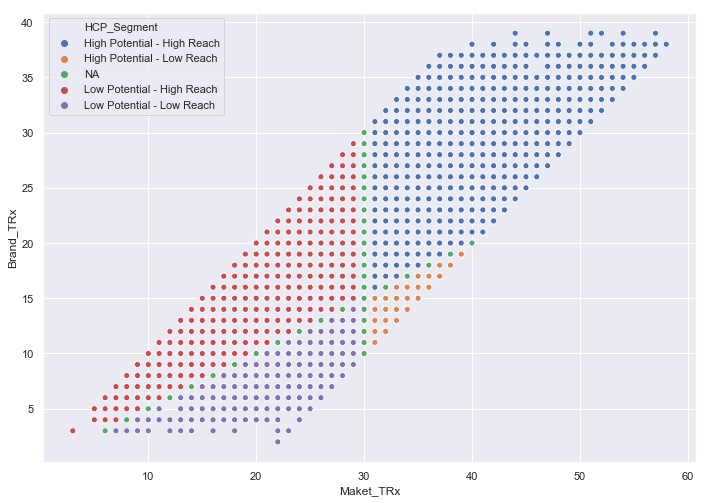

In [599]:
sns.scatterplot(x="Maket_TRx" , y="Brand_TRx",hue="HCP_Segment", data=df_eda)

In [600]:
# Model 2: k-means clustering

In [601]:
# For this model, we target the Brand_TRx and the Maket_TRx. We are going to apply K-means clustering to assign a Brand_TRx score.
# But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply
#tells the optimal cluster number for optimal inertia. 

c:\users\debayandutta\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\debayandutta\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

c:\users\debayandutta\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

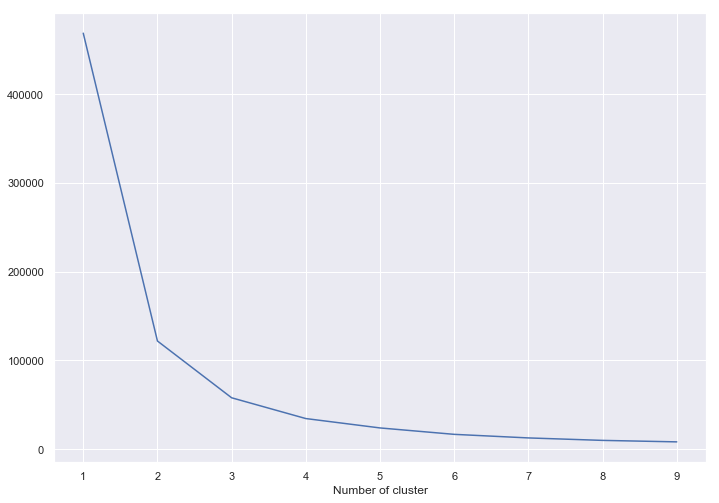

In [602]:
sse={}
brand_TRx = df_master[['Brand_TRx']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(brand_TRx)
    brand_TRx["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [603]:
# Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters.
# We will be selecting 4 for this example:


In [604]:
# Brand_TRx

In [605]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_master[['Brand_TRx']])
df_master['Brand_TRx_Cluster'] = kmeans.predict(df_master[['Brand_TRx']])

In [606]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [607]:
df_master = order_cluster('Brand_TRx_Cluster', 'Brand_TRx',df_master,False)

In [609]:
#Maket_TRx

In [610]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_master[['Maket_TRx']])
df_master['Maket_TRx_Cluster'] = kmeans.predict(df_master[['Maket_TRx']])

#order the Maket_TRx cluster
df_master = order_cluster('Maket_TRx_Cluster', 'Maket_TRx',df_master,True)

#see details of each cluster
df_master.groupby('Maket_TRx_Cluster')['Maket_TRx'].describe()

count       mean       std   min   25%   50%   75%   max
Maket_TRx_Cluster                                                           
0                  1125.0  14.997333  3.804730   3.0  12.0  16.0  18.0  20.0
1                  2134.0  26.405811  3.114367  21.0  24.0  27.0  29.0  31.0
2                  1785.0  36.349020  2.837880  32.0  34.0  36.0  39.0  41.0
3                   979.0  46.598570  3.726767  42.0  43.0  46.0  49.0  58.0

In [611]:
# Overall Score
#calculate overall score and use mean() to see details
df_master['OverallScore'] = df_master['Brand_TRx_Cluster'] + df_master['Maket_TRx_Cluster']
df_master.groupby('OverallScore')['Brand_TRx','Maket_TRx'].mean()

Brand_TRx  Maket_TRx
OverallScore                      
1             28.322034  29.237288
2             25.037690  29.579939
3             19.944056  30.816910
4             14.376577  31.115315
5             12.000000  32.000000

In [612]:
#The scoring above clearly shows us that customers with score 5 is our best customers whereas 1 is the worst.

In [613]:
df_master['Segment_kmeans'] = 'Low-Value'
df_master.loc[df_master['OverallScore']>1,'Segment_kmeans'] = 'Mid-Value' 
df_master.loc[df_master['OverallScore']>3,'Segment_kmeans'] = 'High-Value'

In [614]:
#Brand_TRx vs Market_TRx
graph = df_master.query("Brand_TRx > 0 and Maket_TRx > 0")

plot_data = [
    go.Scatter(
        x=graph.query("Segment_kmeans == 'Low-Value'")['Brand_TRx'],
        y=graph.query("Segment_kmeans == 'Low-Value'")['Maket_TRx'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'red',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=graph.query("Segment_kmeans == 'Mid-Value'")['Brand_TRx'],
        y=graph.query("Segment_kmeans == 'Mid-Value'")['Maket_TRx'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'yellow',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=graph.query("Segment_kmeans == 'High-Value'")['Brand_TRx'],
        y=graph.query("Segment_kmeans == 'High-Value'")['Maket_TRx'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'purple',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Brand_TRx"},
        xaxis= {'title': "Maket_TRx"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [615]:
# Notes: 

### PROBLEM STATEMENT 2:

In [616]:
df_master.head(5)

ID     Region Experience  \
0  IND100353    Midwest          5   
1  IND101081       West          7   
2  IND102169  Northeast         13   
3  IND103812    Midwest         10   
4  IND104474      South          8   

                                            Feedback           Speciality  \
0  Caller called yesterday, but she did not recei...  PHYSICIAN ASSISTANT   
1  follow up on open case. Call disconnected befo...           PEDIATRICS   
2  Med shipped Wed. Should have been delivered Th...  PHYSICIAN ASSISTANT   
3  when he recieved the MED today the bottom was ...  PHYSICIAN ASSISTANT   
4    Office closes in 1 hour and need to fill ASAP.            PEDIATRICS   

   Coverage  Population  Brand_TRx  Maket_TRx  TRx_Ratio  Call  Email  Web  \
0      52.5     6053454       21.0       32.0   0.656250   2.0    2.0  4.0   
1      63.5     5648044       25.0       38.0   0.657895   1.0    3.0  2.0   
2      52.2     5725589       24.0       33.0   0.727273   2.0    2.0  2.0   
3      59.7     7179553       25.0       33.0   0.757576   1.0    1.0  4.0   
4      45.8     4620923       20.0       33.0   0.606061   2.0    4.0  0.0   

   Total_Spending                  HCP_Segment Experience_c  \
0           212.0  High Potential - High Reach          Bad   
1           118.0  High Potential - High Reach         Good   
2           212.0  High Potential - High Reach        Great   
3           106.0  High Potential - High Reach        Great   
4           224.0  High Potential - High Reach         Good   

   Brand_TRx_Cluster  Maket_TRx_Cluster  OverallScore Segment_kmeans  
0                  1                  2             3      Mid-Value  
1                  1                  2             3      Mid-Value  
2                  1                  2             3      Mid-Value  
3                  1                  2             3      Mid-Value  
4                  1                  2             3      Mid-Value

In [617]:
df_reg = df_master.drop(['Feedback', 'Speciality', 'HCP_Segment', 'Experience_c','Brand_TRx_Cluster','OverallScore','Segment_kmeans','Maket_TRx_Cluster'], axis = 1)

In [618]:
#df_reg.head(5)

In [619]:
df_reg = df_reg[df_reg['Experience']!='-1']

In [620]:
df_reg.corr()

Coverage  Population  Brand_TRx  Maket_TRx  TRx_Ratio  \
Coverage        1.000000   -0.005306   0.974389   0.803861   0.505822   
Population     -0.005306    1.000000   0.001277  -0.005963   0.005240   
Brand_TRx       0.974389    0.001277   1.000000   0.825378   0.521272   
Maket_TRx       0.803861   -0.005963   0.825378   1.000000  -0.019556   
TRx_Ratio       0.505822    0.005240   0.521272  -0.019556   1.000000   
Call           -0.036161    0.005503  -0.005437  -0.009064   0.007781   
Email           0.009020   -0.016155   0.037821   0.024509   0.027909   
Web             0.026956    0.012680   0.056870   0.063598   0.010682   
Total_Spending -0.034619    0.003993  -0.002059  -0.006758   0.010024   

                    Call     Email       Web  Total_Spending  
Coverage       -0.036161  0.009020  0.026956       -0.034619  
Population      0.005503 -0.016155  0.012680        0.003993  
Brand_TRx      -0.005437  0.037821  0.056870       -0.002059  
Maket_TRx      -0.009064  0.024509  0.063598       -0.006758  
TRx_Ratio       0.007781  0.027909  0.010682        0.010024  
Call            1.000000  0.203243 -0.210599        0.996425  
Email           0.203243  1.000000 -0.175161        0.285230  
Web            -0.210599 -0.175161  1.000000       -0.221266  
Total_Spending  0.996425  0.285230 -0.221266        1.000000

In [621]:
#Summaries
df_reg.shape

(6013, 12)

In [622]:
#df_reg.describe()
df_reg.head(5)

ID     Region Experience  Coverage  Population  Brand_TRx  \
0  IND100353    Midwest          5      52.5     6053454       21.0   
1  IND101081       West          7      63.5     5648044       25.0   
2  IND102169  Northeast         13      52.2     5725589       24.0   
3  IND103812    Midwest         10      59.7     7179553       25.0   
4  IND104474      South          8      45.8     4620923       20.0   

   Maket_TRx  TRx_Ratio  Call  Email  Web  Total_Spending  
0       32.0   0.656250   2.0    2.0  4.0           212.0  
1       38.0   0.657895   1.0    3.0  2.0           118.0  
2       33.0   0.727273   2.0    2.0  2.0           212.0  
3       33.0   0.757576   1.0    1.0  4.0           106.0  
4       33.0   0.606061   2.0    4.0  0.0           224.0

#### Model 1:

In [623]:
# On Call, Email, Web
#sns.scatterplot(x="Total_Spending", y="Brand_TRx", data=df_reg) 

In [624]:
#sns.lmplot(x ="Call", y ="Brand_TRx", data = df_reg, order = 2, ci = None)

In [625]:
X = df_reg[['Call','Email','Web']].values
y = df_reg['Brand_TRx'].values.reshape(-1,1)

In [626]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [627]:
model_1 = LinearRegression()

In [628]:
model_1.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [629]:
#To retrieve the intercept:
print(model_1.intercept_)

[18.89582243]


In [630]:
#For retrieving the slope:
print(model_1.coef_)

[[0.09822223 0.31400591 0.50204838]]


In [631]:
y_pred = model_1.predict(X_test)

In [632]:
df_model1 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#df_model1

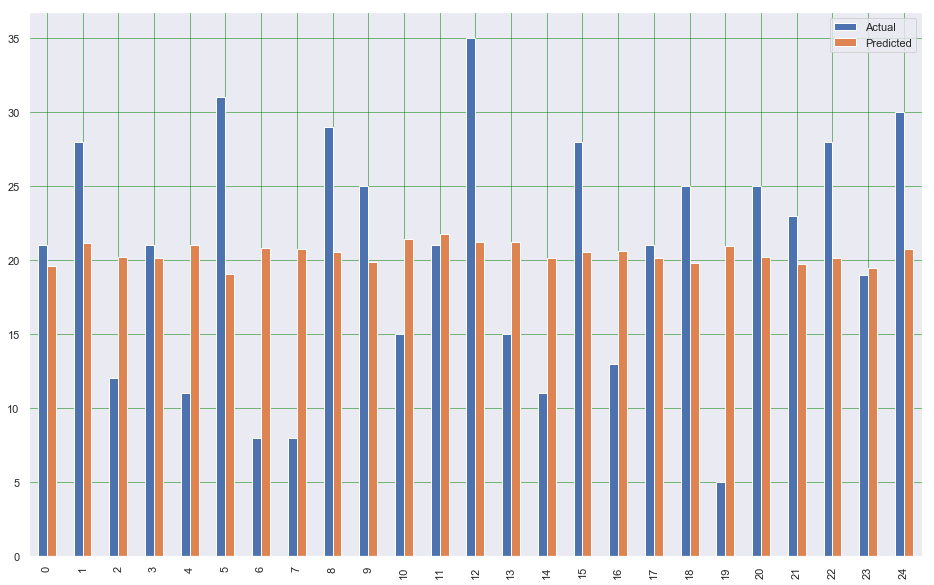

In [633]:
df1 = df_model1.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [634]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 7.464440579588838
Mean Squared Error: 74.98938377824003
Root Mean Squared Error: 8.659641088303834


In [635]:
r2_score(y_test.flatten(), y_pred.flatten())

0.004504560531801705

In [636]:
# Which is not a very good R2 score...which take us to the second model

#### Model 2

In [637]:
X = df_reg[['Coverage','Call','Email','Web']].values
y = df_reg['Brand_TRx'].values.reshape(-1,1)

In [638]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [639]:
model_2 = LinearRegression()

In [640]:
model_2.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [641]:
#To retrieve the intercept:
print(model_2.intercept_)

[3.98870789]


In [642]:
#For retrieving the slope:
print(model_2.coef_)

[[0.30063346 0.3630978  0.22417506 0.30936569]]


In [643]:
y_pred = model_2.predict(X_test)

In [644]:
df_model2 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#df_model1

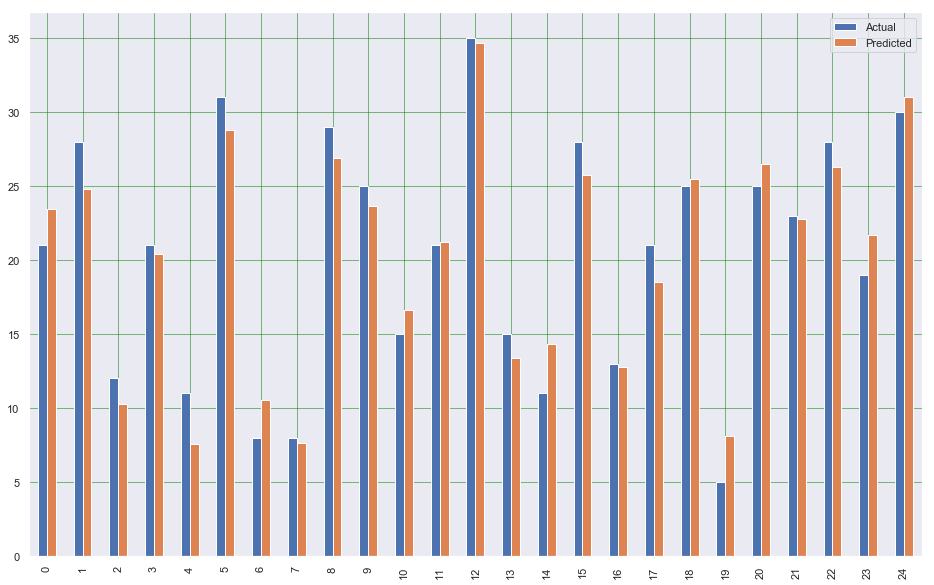

In [645]:
df2 = df_model2.head(25)
df2.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [646]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.6322884930404058
Mean Squared Error: 3.645156119720755
Root Mean Squared Error: 1.909229195178189


In [647]:
r2_score(y_test.flatten(), y_pred.flatten())

0.9516099998359425